In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

import warnings

warnings.filterwarnings('ignore')

C:\Users\vijay\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vijay\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vijay\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vijay\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
TRAIN_PATH = './SPECAB'
VAL_PATH = './SPECAB_VAL'

TRAIN = os.path.join(TRAIN_PATH)
TEST = os.path.join(VAL_PATH)

In [5]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 312
IMG_HEIGHT = 257

In [6]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

In [7]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    print(cropped_image[0].shape,cropped_image[1].shape)
    return cropped_image[0], cropped_image[1]

In [8]:
# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

In [9]:
import numpy as np

def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)
    var = tf.random.uniform(()) 
    if var > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

In [10]:
def loadAB(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    real_image = image[:, w:, :]
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image

In [11]:
def load_image_train(image_file):
    input_image, real_image = loadAB(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    print(input_image.shape,real_image.shape)
    return input_image, real_image

In [12]:
def load_image_test(image_file):
    input_image, real_image = loadAB(image_file)
    input_image, real_image = resize(input_image, real_image,IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    print(input_image.shape,real_image.shape)
    return input_image, real_image

In [13]:
train_dataset = tf.data.Dataset.list_files(TRAIN+'/*.png')
train_dataset = train_dataset.map(load_image_train,num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

(257, 312, 3) (257, 312, 3)
(257, 312, 3) (257, 312, 3)


In [14]:
test_dataset = tf.data.Dataset.list_files(TEST+'/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

(257, 312, None) (257, 312, None)


In [15]:
OUTPUT_CHANNELS = 3

In [16]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization(fused=False))
    
    result.add(tf.keras.layers.LeakyReLU())

    return result

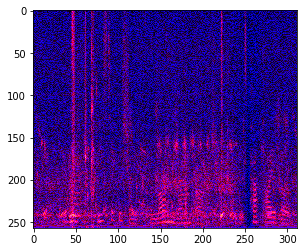

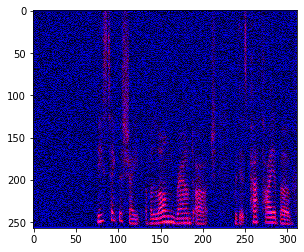

In [17]:
inp, re = loadAB(TRAIN+'/'+'mif_02484_00860023244.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [18]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 257, 312, 3)


In [19]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=1,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization(fused=False))

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [20]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 257, 312, 3)


In [21]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH,3])
    
    
    down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
    ]
    
#     down_stack = [
#     downsample(64, 4,  apply_batchnorm=False),
#     downsample(128, 4),
#     downsample(256, 4),
#     downsample(256, 4),
#     downsample(256, 4),
#     downsample(256, 4),
#     downsample(256, 4),
#     downsample(256, 4),
#     downsample(256, 4),
#     downsample(256, 4),
#     downsample(512, 4),
#     downsample(1024, 4),
#     ]

#     up_stack = [
#     upsample(1024, 4,apply_dropout=True),
#     upsample(512, 4,apply_dropout=True),
#     upsample(256, 4),
#     upsample(256, 4),
#     upsample(256, 4),
#     upsample(256, 4),
#     upsample(256, 4),
#     upsample(256, 4),
#     upsample(256, 4),
#     upsample(128, 4),
#     upsample(64, 4),
#     ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=1,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        print(x.shape)
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    print('\n')
    
  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        print(x.shape)
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

(None, 257, 312, 3)
(None, 257, 312, 64)
(None, 257, 312, 128)
(None, 257, 312, 256)
(None, 257, 312, 512)
(None, 257, 312, 512)
(None, 257, 312, 512)
(None, 257, 312, 512)


(None, 257, 312, 512)
(None, 257, 312, 1024)
(None, 257, 312, 1024)
(None, 257, 312, 1024)
(None, 257, 312, 1024)
(None, 257, 312, 512)
(None, 257, 312, 256)


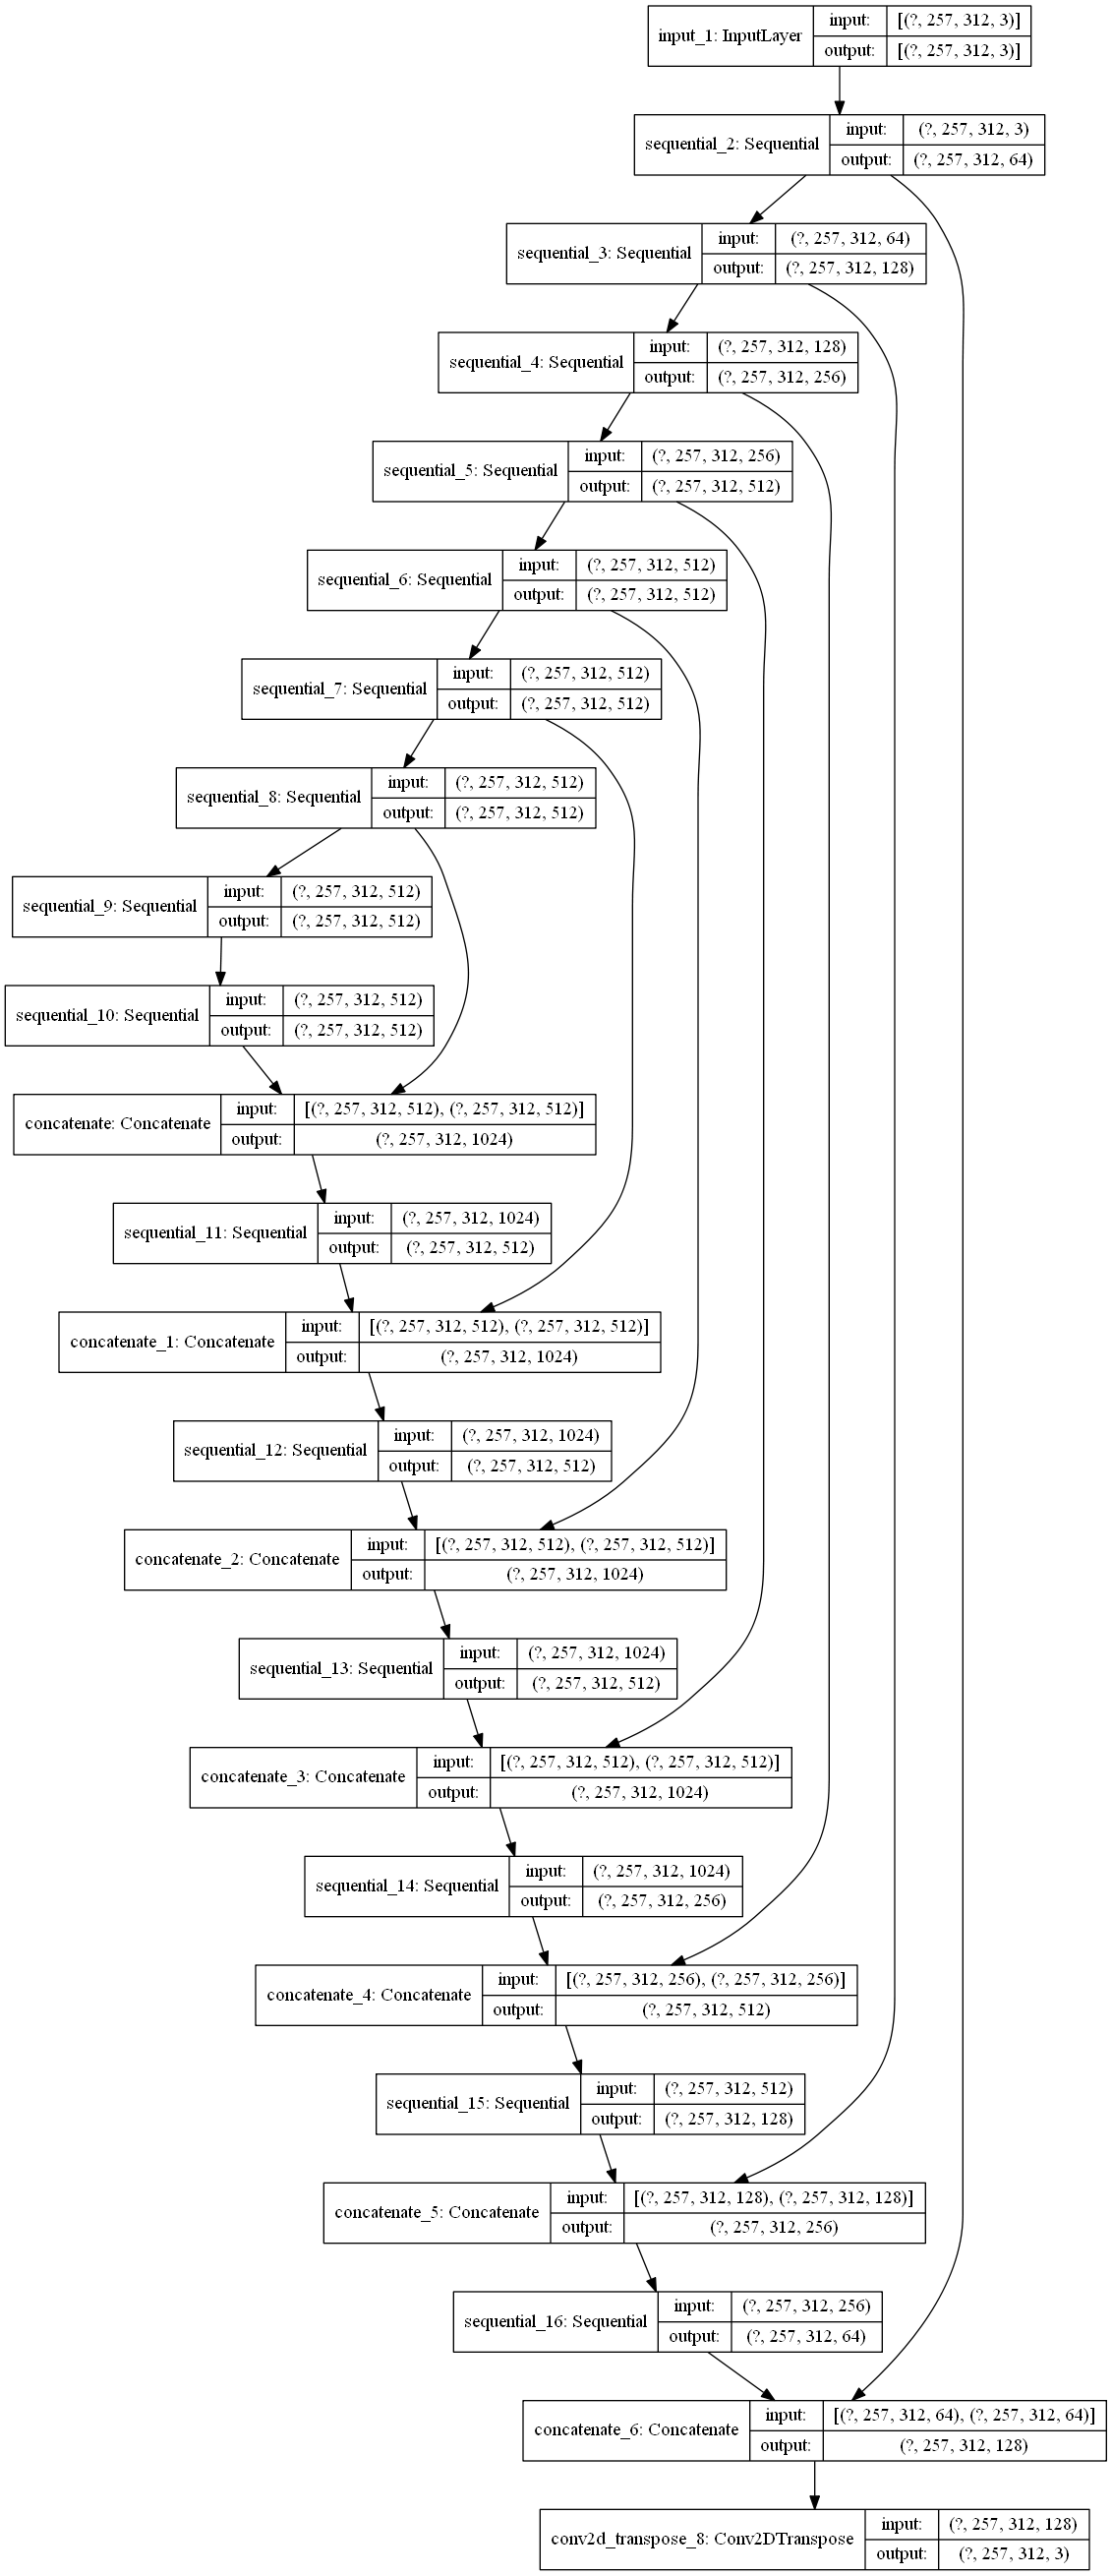

In [22]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


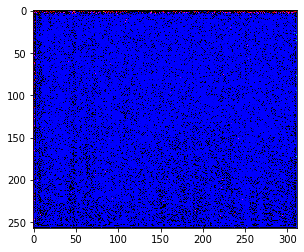

In [23]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [24]:
LAMBDA = 100

In [25]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [26]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='target_image')

#     print(inp.shape,tar.shape)
    
    x = tf.keras.layers.concatenate([inp, tar])

    
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
        
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

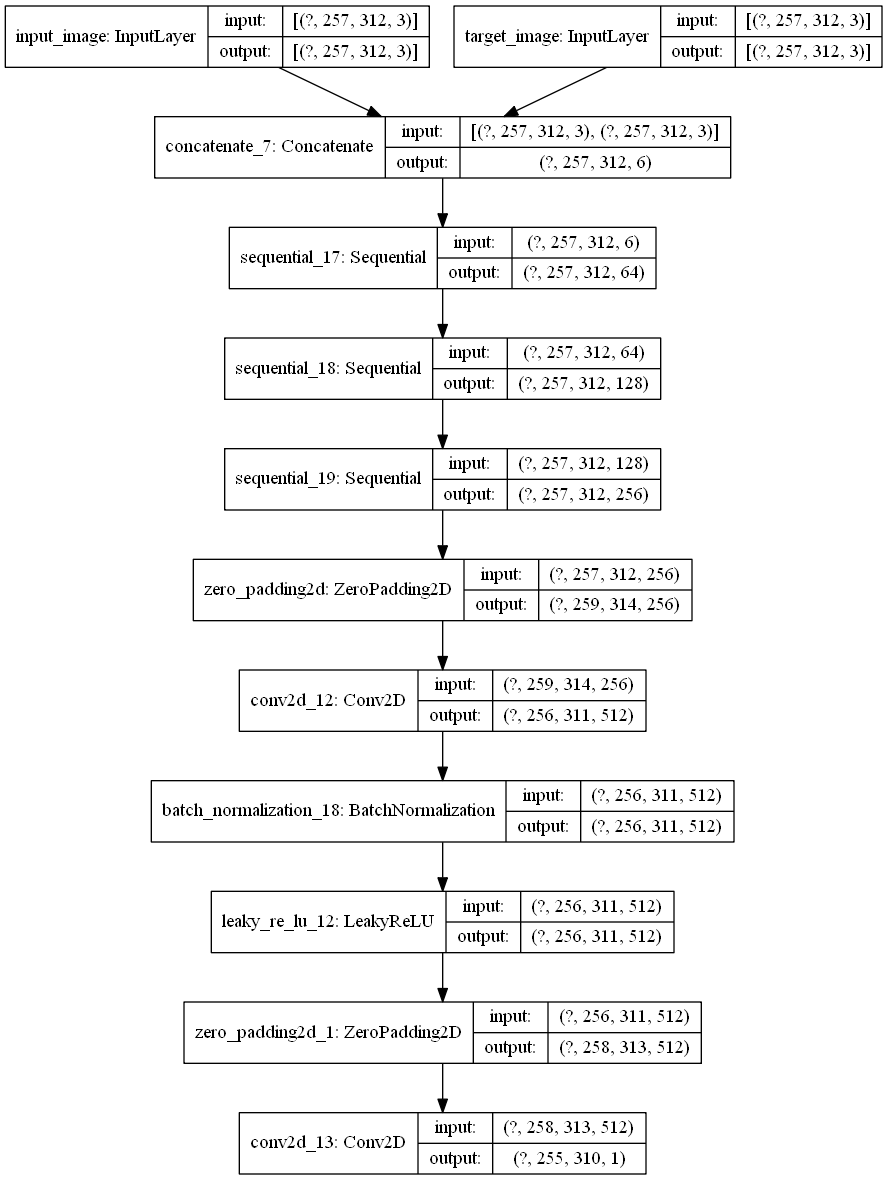

In [27]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True)

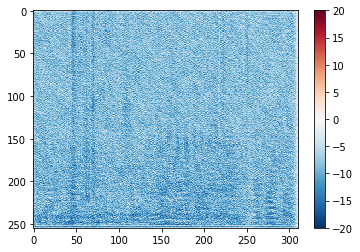

In [28]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [29]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [32]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [33]:
import imageio
from PIL import Image

In [34]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))
    
    imageio.imwrite('predicted.png', prediction[0])
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

Lossy conversion from float32 to uint8. Range [-0.9831897020339966, 0.9519566893577576]. Convert image to uint8 prior to saving to suppress this warning.


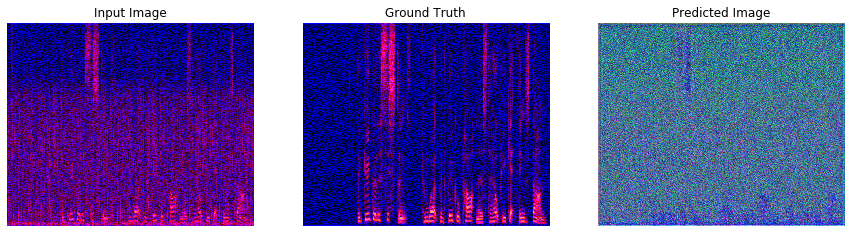

In [35]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [36]:
EPOCHS = 10000

In [37]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [38]:

# @tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [39]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        
        display.clear_output(wait=True)
        
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)
        
        # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
        
        if (n+1) % 100 == 0:
            print()
            train_step(input_image, target, epoch)
        print()

        # saving (checkpoint) the model every 50 epochs
        if (epoch + 1) % 300 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)

In [40]:
# fit(test_dataset, EPOCHS, train_dataset)
fit(train_dataset, EPOCHS, test_dataset)

KeyboardInterrupt: 

# Test the theory - Noise removed from speech

# Recover Wav File From Spectrogram Image

In [ ]:
import numpy as np
import math
from PIL import Image
import time

In [ ]:
# Packages we're using
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage

In [ ]:
FFT_LENGTH = 512
WINDOW_LENGTH = 512
WINDOW_STEP = int(WINDOW_LENGTH / 2)
magnitudeMin = float("inf")
magnitudeMax = float("-inf")
phaseMin = float("inf")
phaseMax = float("-inf")

In [ ]:
def amplifyMagnitudeByLog(d):
    return 188.301 * math.log10(d + 1)

def weakenAmplifiedMagnitude(d):
    return math.pow(10, d/188.301)-1

def generateLinearScale(magnitudePixels, phasePixels, 
                        magnitudeMin, magnitudeMax, phaseMin, phaseMax):
    height = magnitudePixels.shape[0]
    width = magnitudePixels.shape[1]
    magnitudeRange = magnitudeMax - magnitudeMin
    phaseRange = phaseMax - phaseMin
    rgbArray = np.zeros((height, width, 3), 'uint8')
    
    for w in range(width):
        for h in range(height):
            magnitudePixels[h,w] = (magnitudePixels[h,w] - magnitudeMin) / (magnitudeRange) * 255 * 2
            magnitudePixels[h,w] = amplifyMagnitudeByLog(magnitudePixels[h,w])
            phasePixels[h,w] = (phasePixels[h,w] - phaseMin) / (phaseRange) * 255
            red = 255 if magnitudePixels[h,w] > 255 else magnitudePixels[h,w]
            green = (magnitudePixels[h,w] - 255) if magnitudePixels[h,w] > 255 else 0
            blue = phasePixels[h,w]
            rgbArray[h,w,0] = int(red)
            rgbArray[h,w,1] = int(green)
            rgbArray[h,w,2] = int(blue)
    return rgbArray

def recoverLinearScale(rgbArray, magnitudeMin, magnitudeMax, 
                       phaseMin, phaseMax):
    width = rgbArray.shape[1]
    height = rgbArray.shape[0]
    magnitudeVals = rgbArray[:,:,0].astype(float) + rgbArray[:,:,1].astype(float)
    phaseVals = rgbArray[:,:,2].astype(float)
    phaseRange = phaseMax - phaseMin
    magnitudeRange = magnitudeMax - magnitudeMin
    for w in range(width):
        for h in range(height):
            phaseVals[h,w] = (phaseVals[h,w] / 255 * phaseRange) + phaseMin
            magnitudeVals[h,w] = weakenAmplifiedMagnitude(magnitudeVals[h,w])
            magnitudeVals[h,w] = (magnitudeVals[h,w] / (255*2) * magnitudeRange) + magnitudeMin
    return magnitudeVals, phaseVals

In [ ]:
rate = 16000

def recoverSignalFromSpectrogram(filePath):
    img = Image.open(filePath)
    data = np.array( img, dtype='uint8' )
    width = data.shape[1]
    height = data.shape[0]

    magnitudeVals, phaseVals \
    = recoverLinearScale(data, magnitudeMin, magnitudeMax, phaseMin, phaseMax)
    
    recovered = np.zeros(WINDOW_LENGTH * width // 2 + WINDOW_STEP, dtype=np.int16)
    recovered = np.array(recovered,dtype=np.int16)
    
    for w in range(width):
        toInverse = np.zeros(height, dtype=np.complex_)
        for h in range(height):
            magnitude = magnitudeVals[height-h-1,w]
            phase = phaseVals[height-h-1,w]
            toInverse[h] = magnitude * math.cos(phase) + (1j * magnitude * math.sin(phase))
        signal = np.fft.irfft(toInverse)
        recovered[w*WINDOW_STEP:w*WINDOW_STEP + WINDOW_LENGTH] += signal[:WINDOW_LENGTH].astype(np.int16)
    return recovered

In [ ]:
data = recoverSignalFromSpectrogram('./'+'predicted.png')
scipy.io.wavfile.write('./'+'recovered.wav', rate, data)